<a href="https://colab.research.google.com/github/JayNguyen-123/DATA_ANALYST_AI_AGENT/blob/main/Data_Analyst_Agent_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Analysis Agent AI
In today’s world, businesses and organizations rely heavily on data to make informed decisions. However, analyzing large amounts of data can be a time-consuming and daunting task. That’s where automation comes into play.

Introduction AI Agent for data analysis: This AI automation can interpert your question using OpenAI function calling and generate accurate answers with charts.

### The Architecture

- Loading and Insoection: Load data from various formats/sources and also present a first set of impressions about structure, data types, and basic statistics. Consider these as the AI’s getting-familiar phase with your data.

- Statistic Analysis: These functions offer mathematical interpretations of data from basic descriptive statistics to more complex correlation analyses. They are designed to yield results presented in formats appropriate for the AI interpretation and for the user component descriptions.

- Visualization: These functions will produce charts, graphs, and plots as the AI determines the analysis. It is very important that they be flexible enough to handle various data types and still produce outputs readable by humans.

- Filtering and Data Transformation: Through these, the AI can cut, dice, and reshape data according to the user query.



### Install required package

In [1]:

!pip install openai


### Import libaries

In [84]:
import openai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
import json
import warnings
warnings.filterwarnings("ignore")
from google.colab import userdata
import getpass



### Generate sample E-commercial data

In [85]:
def generate_sample_data():
    """Generate realistic e-commerce sales data for demonstration"""
    np.random.seed(42)

    # Product categories and names
    categories = ['Electronics', 'Clothing', 'Books', 'Home & Garden', 'Sports']
    products = {
        'Electronics': ['Smartphone', 'Laptop', 'Headphones', 'Tablet', 'Smart Watch'],
        'Clothing': ['T-Shirt', 'Jeans', 'Sneakers', 'Jacket', 'Dress'],
        'Books': ['Fiction Novel', 'Science Book', 'Cookbook', 'Biography', 'Self-Help'],
        'Home & Garden': ['Coffee Maker', 'Plant Pot', 'Lamp', 'Pillow', 'Rug'],
        'Sports': ['Running Shoes', 'Yoga Mat', 'Dumbbell', 'Basketball', 'Tennis Racket']
    }

    # Generate data for the last 12 months
    start_date = datetime.now() - timedelta(days=365)
    dates = pd.date_range(start=start_date, end=datetime.now(), freq='D')

    data = []
    customer_id = 1000

    for date in dates:
        # Simulate seasonal patterns
        month = date.month
        seasonal_multiplier = 1.2 if month in [11, 12] else (1.1 if month in [6, 7] else 1.0)

        # Generate 10-50 orders per day
        daily_orders = np.random.poisson(25 * seasonal_multiplier)

        for _ in range(daily_orders):
            category = np.random.choice(categories, p=[0.3, 0.25, 0.15, 0.15, 0.15])
            product = np.random.choice(products[category])

            # Price based on category
            price_ranges = {
                'Electronics': (50, 1000),
                'Clothing': (15, 200),
                'Books': (10, 50),
                'Home & Garden': (20, 300),
                'Sports': (25, 250)
            }

            price = np.random.uniform(*price_ranges[category])
            quantity = np.random.choice([1, 2, 3], p=[0.7, 0.2, 0.1])

            data.append({
                'date': date,
                'customer_id': customer_id,
                'product_name': product,
                'category': category,
                'quantity': quantity,
                'unit_price': round(price, 2),
                'total_amount': round(price * quantity, 2)
            })

            customer_id += 1

    return pd.DataFrame(data)

# Generate and display sample data
df = generate_sample_data()
print(f"✅ Generated {len(df)} sales records")
print("\n📊 Sample Data Preview:")
print(df.head())
print(f"\n📈 Date Range: {df['date'].min()} to {df['date'].max()}")
print(f"💰 Total Revenue: ${df['total_amount'].sum():.2f}")


✅ Generated 9652 sales records

📊 Sample Data Preview:
                        date  customer_id product_name       category  \
0 2024-11-27 18:52:39.309564         1000          Rug  Home & Garden   
1 2024-11-27 18:52:39.309564         1001   Headphones    Electronics   
2 2024-11-27 18:52:39.309564         1002          Rug  Home & Garden   
3 2024-11-27 18:52:39.309564         1003       Tablet    Electronics   
4 2024-11-27 18:52:39.309564         1004       Jacket       Clothing   

   quantity  unit_price  total_amount  
0         1      187.12        187.12  
1         1      872.87        872.87  
2         2      291.57        583.15  
3         1      224.23        224.23  
4         1       19.27         19.27  

📈 Date Range: 2024-11-27 18:52:39.309564 to 2025-11-27 18:52:39.309564
💰 Total Revenue: $3154863.42


### Define analysis functions


In [86]:
class DataAnalyzer:
    def __init__(self, dataframe):
        self.df = dataframe.copy()
        self.df['date'] = pd.to_datetime(self.df['date'])

    def get_revenue_summary(self, period='monthly'):
        """Calculate revenue summary by time period"""
        try:
            # Define a frequency string compatible with pd.Grouper
            if period == 'daily':
                freq = 'D'
            elif period == 'weekly':
                # Use 'W-MON' to define a specific weekly start day (e.g., Monday)
                freq = 'W-MON'
            elif period == 'monthly':
                freq = 'M'
            else:
                return {"error": "Invalid period. Use 'daily', 'weekly', or 'monthly'"}

            # Use pd.Grouper for robust time-series grouping
            grouped = self.df.groupby(pd.Grouper(key='date', freq=freq))

            revenue_data = grouped['total_amount'].sum().reset_index()
            revenue_data.columns = ['period', 'revenue']

            # Format the 'period' column for cleaner output (e.g., YYYY-MM or YYYY-MM-DD)
            if period == 'monthly':
                revenue_data['period'] = revenue_data['period'].dt.to_period('M').astype(str)
            elif period == 'daily':
                revenue_data['period'] = revenue_data['period'].dt.date.astype(str)
            # Weekly periods will use the end date of the period by default when using freq='W'

            # Calculate summaries after grouping
            total_revenue = float(self.df['total_amount'].sum())
            average_revenue = float(revenue_data['revenue'].mean())

            return {
                "success": True,
                "data": revenue_data.to_dict('records'),
                "total_revenue": total_revenue,
                "average_revenue": average_revenue,
                "period": period
            }
        except Exception as e:
            # Return a generic exception message if something unexpected occurs
            return {"error": str(e)}

    def get_top_products(self, limit=10, metric='revenue'):
        """Get top performing products"""
        try:
            if metric == 'revenue':
                top_products = self.df.groupby('product_name')['total_amount'].sum().sort_values(ascending=False).head(limit)
            elif metric == 'quantity':
                top_products = self.df.groupby('product_name')['quantity'].sum().sort_values(ascending=False).head(limit)
            else:
                return {"error": "Invalid metric. Use 'revenue' or 'quantity'"}

            return {
                "success": True,
                "data": [{"product": prod, "value": float(val)} for prod, val in top_products.items()],
                "metric": metric,
                "limit": limit
            }
        except Exception as e:
            return {"error": str(e)}

    def get_category_performance(self):
        """Analyze performance by product category"""
        try:
            category_stats = self.df.groupby('category').agg({
                'total_amount': ['sum', 'mean'],
                'quantity': 'sum',
                'customer_id': 'nunique'
            }).round(2)

            category_stats.columns = ['total_revenue', 'avg_order_value', 'total_quantity', 'unique_customers']
            category_stats = category_stats.reset_index()

            return {
                "success": True,
                "data": category_stats.to_dict('records')
            }
        except Exception as e:
            return {"error": str(e)}

    def get_customer_insights(self):
        """Analyze customer behavior patterns"""
        try:
            customer_stats = self.df.groupby('customer_id').agg({
                'total_amount': 'sum',
                'date': ['min', 'max', 'nunique']
            }).round(2)

            customer_stats.columns = ['total_spent', 'first_purchase', 'last_purchase', 'purchase_frequency']

            insights = {
                "total_customers": len(customer_stats),
                "avg_customer_value": float(customer_stats['total_spent'].mean()),
                "avg_purchase_frequency": float(customer_stats['purchase_frequency'].mean()),
                "top_spenders": customer_stats.nlargest(5, 'total_spent')['total_spent'].to_dict()
            }

            return {"success": True, "data": insights}
        except Exception as e:
            return {"error": str(e)}

    def create_visualization(self, chart_type, data_params):
        """Create various types of visualizations"""
        try:
            plt.figure(figsize=(12, 6))

            if chart_type == 'revenue_trend':
                # Monthly revenue trend
                monthly_data = self.df.groupby(self.df['date'].dt.to_period('M'))['total_amount'].sum()
                plt.plot(range(len(monthly_data)), monthly_data.values, marker='o', linewidth=2)
                plt.title('Monthly Revenue Trend', fontsize=16, fontweight='bold')
                plt.xlabel('Month')
                plt.ylabel('Revenue ($)')
                plt.xticks(range(len(monthly_data)), [str(x) for x in monthly_data.index], rotation=45)
                plt.grid(True, alpha=0.3)

            elif chart_type == 'category_pie':
                # Category revenue distribution
                category_revenue = self.df.groupby('category')['total_amount'].sum()
                plt.pie(category_revenue.values, labels=category_revenue.index, autopct='%1.1f%%', startangle=90)
                plt.title('Revenue Distribution by Category', fontsize=16, fontweight='bold')

            elif chart_type == 'top_products_bar':
                # Top products bar chart
                top_products = self.df.groupby('product_name')['total_amount'].sum().sort_values(ascending=False).head(10)
                plt.bar(range(len(top_products)), top_products.values)
                plt.yticks(range(len(top_products)), top_products.index)
                plt.title('Top 10 Products by Revenue', fontsize=16, fontweight='bold')
                plt.xlabel('Revenue ($)')

            plt.tight_layout()
            plt.show()

            return {"success": True, "message": f"Created {chart_type} visualization"}

        except Exception as e:
            return {"error": str(e)}

# Initialize analyzer
analyzer = DataAnalyzer(df)
print("✅ Data Analyzer initialized successfully!")

✅ Data Analyzer initialized successfully!


### Function definitions for OpenAI

In [87]:
def get_revenue_summary(period='monthly'):
    """Get revenue summary by time period (daily, weekly, monthly)"""
    return analyzer.get_revenue_summary(period)

def get_top_products(limit=10, metric='revenue'):
    """Get top performing products by revenue or quantity"""
    return analyzer.get_top_products(limit, metric)

def get_category_performance():
    """Analyze performance metrics by product category"""
    return analyzer.get_category_performance()

def get_customer_insights():
    """Get insights about customer behavior and patterns"""
    return analyzer.get_customer_insights()

def create_visualization(chart_type, data_params=None):
    """Create visualizations (revenue_trend, category_pie, top_products_bar)"""
    return analyzer.create_visualization(chart_type, data_params or {})

def get_basic_stats():
    """Get basic statistics about the dataset"""
    return {
        "success": True,
        "data": {
            "total_records": len(analyzer.df),
            "date_range": {
                "start": str(analyzer.df['date'].min().date()),
                "end": str(analyzer.df['date'].max().date())
            },
            "total_revenue": float(analyzer.df['total_amount'].sum()),
            "unique_products": analyzer.df['product_name'].nunique(),
            "unique_customers": analyzer.df['customer_id'].nunique(),
            "categories": analyzer.df['category'].unique().tolist()
        }
    }

### OpenAI function schema


In [88]:
functions = [
    {
        "name": "get_revenue_summary",
        "description": "Get revenue summary grouped by time period",
        "parameters": {
            "type": "object",
            "properties": {
                "period": {
                    "type": "string",
                    "enum": ["daily", "weekly", "monthly"],
                    "description": "Time period for grouping revenue data"
                }
            },
            "required": ["period"]
        }
    },
    {
        "name": "get_top_products",
        "description": "Get top performing products by revenue or quantity",
        "parameters": {
            "type": "object",
            "properties": {
                "limit": {
                    "type": "integer",
                    "description": "Number of top products to return (default: 10)"
                },
                "metric": {
                    "type": "string",
                    "enum": ["revenue", "quantity"],
                    "description": "Metric to rank products by"
                }
            },
            "required": ["metric"]
        }
    },
    {
        "name": "get_category_performance",
        "description": "Analyze performance metrics by product category including revenue, quantity, and customers",
        "parameters": {
            "type": "object",
            "properties": {}
        }
    },
    {
        "name": "get_customer_insights",
        "description": "Get insights about customer behavior, spending patterns, and purchase frequency",
        "parameters": {
            "type": "object",
            "properties": {}
        }
    },
    {
        "name": "create_visualization",
        "description": "Create data visualizations like charts and graphs",
        "parameters": {
            "type": "object",
            "properties": {
                "chart_type": {
                    "type": "string",
                    "enum": ["revenue_trend", "category_pie", "top_products_bar"],
                    "description": "Type of chart to create"
                },
                "data_params": {
                    "type": "object",
                    "description": "Additional parameters for the chart"
                }
            },
            "required": ["chart_type"]
        }
    },
    {
        "name": "get_basic_stats",
        "description": "Get basic statistics and overview of the dataset",
        "parameters": {
            "type": "object",
            "properties": {}
        }
    }
]

print("✅ Function schemas defined successfully!")


✅ Function schemas defined successfully!


### Main AI Agent class

In [89]:
from matplotlib.artist import get
class DataAnalystAI:
    def __init__(self, api_key):
        self.client = openai.OpenAI(api_key=api_key)
        self.functions = {
            "get_revenue_summary": get_revenue_summary,
            "get_top_products": get_top_products,
            "get_category_performance": get_category_performance,
            "get_customer_insights": get_customer_insights,
            "create_visualization": create_visualization,
            "get_basic_stats": get_basic_stats
        }
        self.conversation_history = []

    def process_query(self, user_query):
        """Process user query and return AI response with function calls"""
        try:
            # Add user message to conversation
            messages = [
                {
                    "role": "system",
                    "content": """You are a helpful data analyst AI assistant. You can analyze e-commerce sales data and create visualizations.
                    Always provide clear, actionable insights. When showing numerical data, format it nicely with commas for large numbers.
                    If you create visualizations, mention that the chart has been displayed.
                    Be conversational and explain your findings in business terms."""
                },
                {"role": "user", "content": user_query}
            ]

            # Add conversation history
            messages = messages[:-1] + self.conversation_history + messages[-1:]

            # Call OpenAI API with function calling
            response = self.client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=messages,
                functions=functions,
                function_call="auto",
                temperature=0.7
            )

            message = response.choices[0].message

            # Handle function calls
            if message.function_call:
                function_name = message.function_call.name
                function_args = json.loads(message.function_call.arguments)

                print(f"🔧 Calling function: {function_name} with args: {function_args}")

                # Execute the function
                function_result = self.functions[function_name](**function_args)

                # Get AI's interpretation of the results
                messages.append({
                    "role": "assistant",
                    "content": None,
                    "function_call": {
                        "name": function_name,
                        "arguments": message.function_call.arguments
                    }
                })

                messages.append({
                    "role": "function",
                    "name": function_name,
                    "content": json.dumps(function_result)
                })

                # Get final response from AI
                final_response = self.client.chat.completions.create(
                    model="gpt-3.5-turbo",
                    messages=messages,
                    temperature=0.7
                )

                ai_response = final_response.choices[0].message.content

                # Update conversation history
                self.conversation_history.append({"role": "user", "content": user_query})
                self.conversation_history.append({"role": "assistant", "content": ai_response})

                return ai_response

            else:
                # No function call needed
                ai_response = message.content
                self.conversation_history.append({"role": "user", "content": user_query})
                self.conversation_history.append({"role": "assistant", "content": ai_response})
                return ai_response

        except Exception as e:
            return f"❌ Error processing query: {str(e)}"

# Initialize the AI agent
ai_agent = DataAnalystAI(getpass.getpass("your-openai-api-key-here"))  # Replace with your API key
print("✅ AI Data Analyst Agent initialized successfully!")


your-openai-api-key-here··········
✅ AI Data Analyst Agent initialized successfully!


### Simple interactive query interface

🚀 Let's test our AI Data Analyst Agent with some example queries:

🙋 Question: Give me an overview of our sales data
🤖 AI Response:
🔧 Calling function: get_basic_stats with args: {}
We have a total of 9,652 sales records from November 27, 2024, to November 27, 2025, across various categories such as Home & Garden, Electronics, Clothing, Sports, and Books. 

- Total Revenue: $3,154,863.42
- Unique Products Sold: 25
- Unique Customers: 9,652

This data gives us a snapshot of our sales performance over the past year. If you'd like a more detailed analysis or specific insights, feel free to ask!


🙋 Question: Show me the monthly revenue trend
🤖 AI Response:
🔧 Calling function: get_revenue_summary with args: {'period': 'monthly'}
The monthly revenue trend over the past year shows some fluctuations but overall a positive trajectory. 

- The highest revenue was in December 2024, reaching $327,068.74, possibly due to holiday season sales.
- The lowest revenue was in April 2025, at $226,887.14,

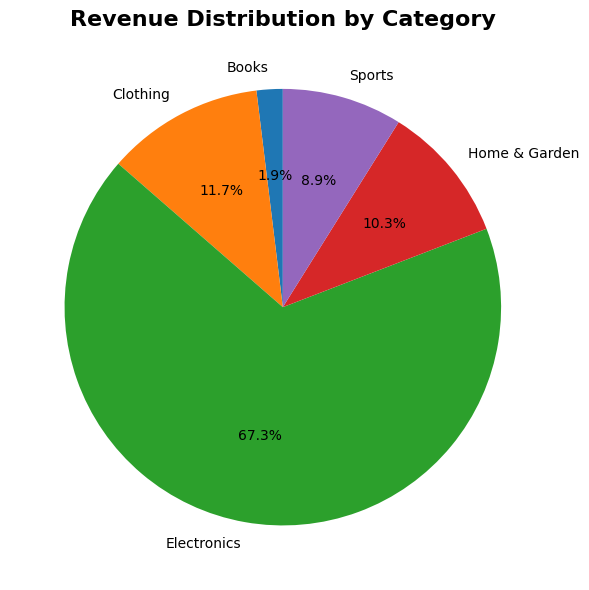

I have created a pie chart showing the distribution of revenue by category. This visualization provides a clear overview of how revenue is distributed across different product categories. If you have any specific questions or need further analysis based on this chart, feel free to ask!


🙋 Question: Which product category generates the highest average order value?
🤖 AI Response:
The product category that generates the highest average order value is **Electronics**. 

- **Electronics** category has an average order value of $745.06, indicating that customers tend to spend more on electronic products in a single order compared to other categories like Clothing, Home & Garden, Books, and Sports.

Understanding the category with the highest average order value can help in pricing strategies, product bundling, and cross-selling initiatives to maximize revenue per transaction. If you need more insights or analysis on customer behavior or product categories, feel free to ask!


🎉 All tests co

In [90]:
def ask_ai(query):
    """Simple interface to ask questions to the AI agent"""
    print(f"🙋 Question: {query}")
    print("🤖 AI Response:")
    response = ai_agent.process_query(query)
    print(response)
    print("\n" + "="*80 + "\n")
    return response

# Cell 9: Example Queries - Run these to test your agent!
print("🚀 Let's test our AI Data Analyst Agent with some example queries:\n")

# Test basic stats
ask_ai("Give me an overview of our sales data")

# Test revenue analysis
ask_ai("Show me the monthly revenue trend")

# Test product analysis
ask_ai("What are our top 5 products by revenue?")

# Test category performance
ask_ai("How are different product categories performing?")

# Test customer insights
ask_ai("Tell me about our customer behavior patterns")

# Test visualization
ask_ai("Create a pie chart showing revenue distribution by category")

# Test comparative analysis
ask_ai("Which product category generates the highest average order value?")

print("🎉 All tests completed! Your AI Data Analyst Agent is ready to use!")
